In [1]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np
import random

import pandas as pd

from numba import jit, cuda

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from tqdm import tqdm, trange
import pickle
import itertools

import networkx as nx
import networkx.algorithms.community as nxcom

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score

## Creating synthetic data

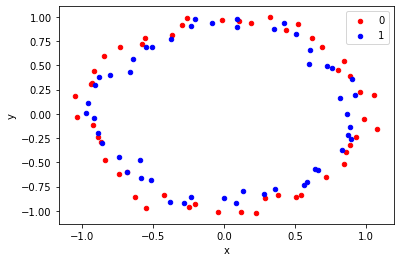

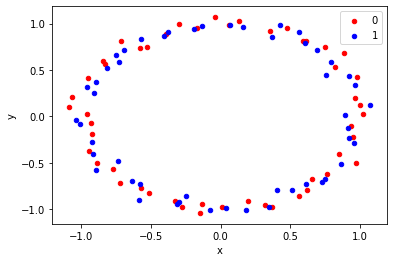

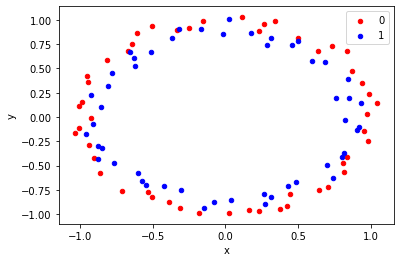

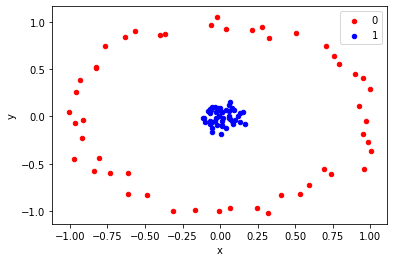

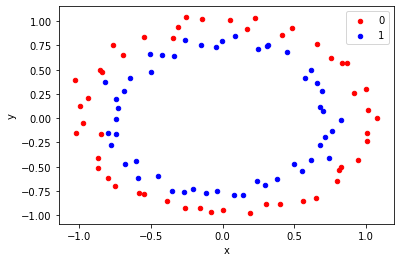

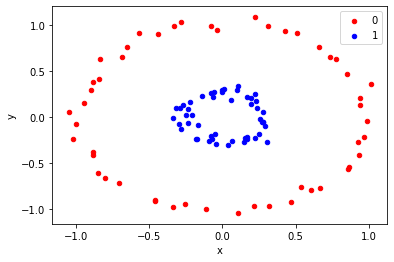

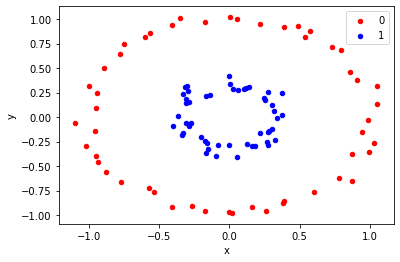

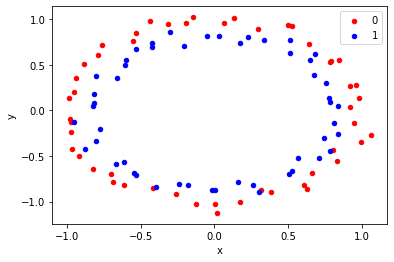

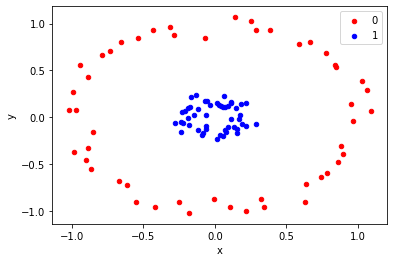

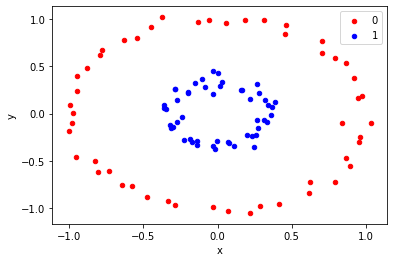

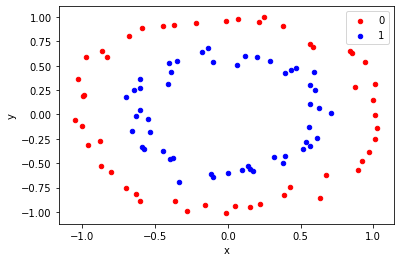

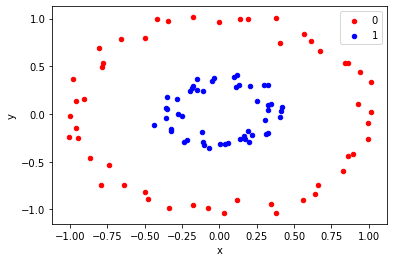

In [2]:
X = []
y = []

## 70% of the data will be biased 
for i in range(0,12):
    # generate 2d classification dataset
    X_prime, y_prime = make_circles(n_samples=100, shuffle=True, noise=0.05, factor=random.uniform(0, 1))#*float(i/10))
    for element in X_prime:
        X.append(list(element))
    y.extend(y_prime)    
    
    df = DataFrame(dict(x=X_prime[:,0], y=X_prime[:,1], label=y_prime))
    
    colors = {0:'red', 1:'blue'}
    fig, ax = pyplot.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    pyplot.show()

In [3]:
df = DataFrame(X,columns=['x','y'])
df['label']=y

In [4]:
#Creating a copy for later useage
df_copy = df.copy()

## See what the overall dataset looks like for now

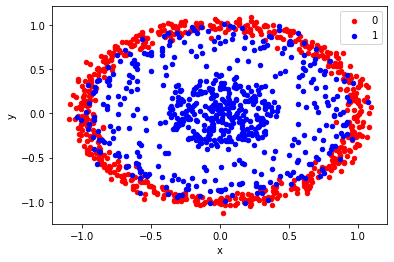

In [5]:
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## Randomly select 75 percent of the data to be biased 

In [6]:
rand_idx = df.sample(frac=0.75).index

## Add a randome bias from a normal distribution

In [7]:

for index in rand_idx:
    if df.loc[index]['label'] == 0:
        df.at[index,'x'] = df.loc[index]['x'] + np.random.normal(5,2)
        df.at[index,'y'] = df.loc[index]['y'] + np.random.normal(5,2)
    else:
        df.at[index,'x'] = df.loc[index]['x'] + np.random.normal(10,3)
        df.at[index,'y'] = df.loc[index]['y'] + np.random.normal(10,3)

## See the new data visualisation

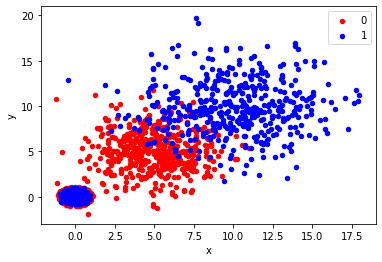

In [8]:
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

The idea here is to have major part of the dataset be easily separable and have certain mathematical relation incorporated in the samples to make it biased 

## Seprate out Test Set for IID verification 

In [9]:
X = df[['x','y']]
y = df.label

# Why this is the IID, because this is from the biased dataset
X_train_iid, X_test_iid, y_train_iid, y_test_iid = train_test_split(X,y, test_size=0.20)

X_prime = df_copy[['x','y']]
y_prime = df_copy.label

# Why this is the OOD, because this is from the Original dataset without entered bias. 
# The notion here is we assume this should have been the original dataset kind 
# which is made out of circles thus not necessariliy linearly separable 
X_train_ood, X_test_ood, y_train_ood, y_test_ood = train_test_split(X_prime,y_prime, test_size=0.80)


In [10]:
df_iid = DataFrame(X_train_iid,columns=['x','y'])
df_iid['label']=y_train_iid

## Experiments for finding Clusters and communities in the given embedding space

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
# @jit
def cosine_similarity_n_space(m1, m2, batch_size=100):
    assert m1.shape[1] == m2.shape[1]
    ret = np.ndarray((m1.shape[0], m2.shape[0]))
    for row_i in tqdm(range(0, int(m1.shape[0] / batch_size) + 1)):
        start = row_i * batch_size
        end = min([(row_i + 1) * batch_size, m1.shape[0]])
        if end <= start:
            break
        rows = m1[start: end]
        sim = cosine_similarity(rows, m2) # rows is O(1) size
        ret[start: end] = sim
    return ret

In [13]:
X_biased = X_train_iid.to_numpy()

In [14]:
npX = np.array(X_biased)
sim = cosine_similarity_n_space(npX,npX, batch_size=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1355.01it/s]


##### This was just the verification of the two similarity techniques we have tried earlier

In [15]:
product = np.dot(npX, npX.T)
norm = np.linalg.norm(npX, axis=1, keepdims=True)
cos_sim = product / np.dot(norm, norm.T)

In [16]:
fltr_sim = cos_sim>0.75


In [17]:
fltr_sim = fltr_sim.astype(int)


In [18]:
fltr_sim

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 0, 1]])

## Make the graph

In [19]:
G = nx.from_numpy_matrix(fltr_sim)

In [20]:
## Basic Checks

In [21]:
nx.is_biconnected(G)

True

In [22]:
list(nx.articulation_points(G))

[]

In [23]:
list(nx.bridges(G))

[]

## Visualizing the graph

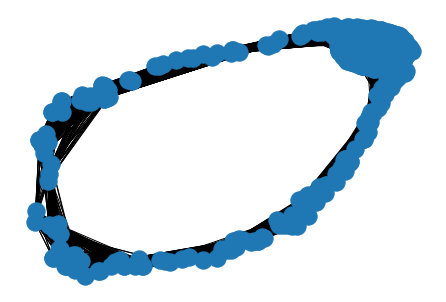

In [24]:
nx.draw(G)## Make the graph

## To-Do
Come back here to exaplain community detectoin might just be ideal in our scenario overall

In [25]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

In [26]:
len(communities)

9

In [27]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)  

In [28]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

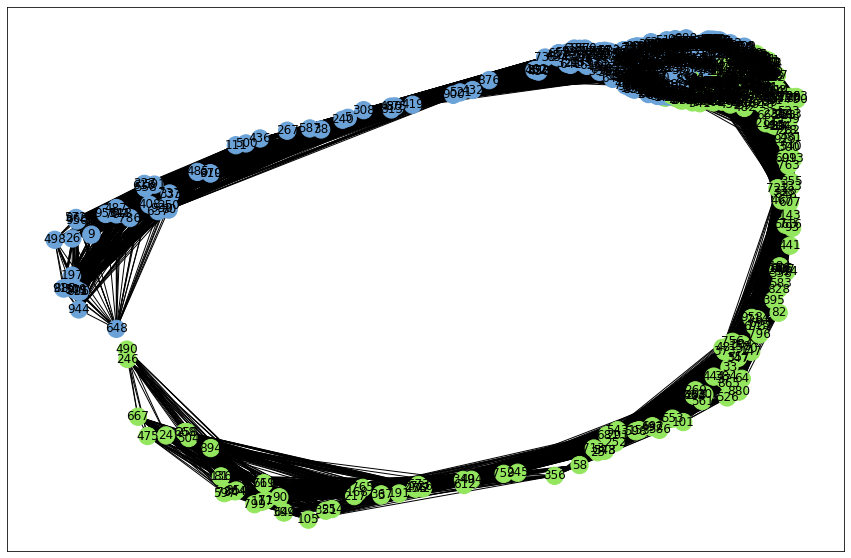

In [29]:
pos = nx.spring_layout(G)

pyplot.rcParams.update({'figure.figsize': (15, 10)})
# # Draw external edges
# nx.draw_networkx(
#     G,
#     pos=pos,
#     node_size=0,
#     edgelist=external,
#     edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    G,
    pos=pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)

Try other latest algorithms to find the communities 

In [30]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(G)

In [31]:
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

In [32]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

In [33]:
pyplot.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
pyplot.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

<Figure size 1368x684 with 0 Axes>

In [34]:
import time
from matplotlib import pyplot as plt

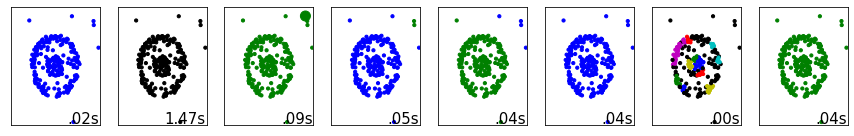

In [35]:
# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(npX, quantile=0.3)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(npX, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
# create clustering estimators
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=2)
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                       connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=2,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=.1)
affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                   preference=-200)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock", n_clusters=2,
    connectivity=connectivity)

birch = cluster.Birch(n_clusters=2)
clustering_algorithms = [
    two_means, affinity_propagation, ms, spectral, ward, average_linkage,
    dbscan, birch]

for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    t0 = time.time()
    algorithm.fit(npX)
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(npX)

    # plot
    plt.subplot(4, len(clustering_algorithms), plot_num)
#     if i_dataset == 0:
#         plt.title(name, size=18)
    plt.scatter(npX[:, 0], npX[:, 1], color=colors[y_pred].tolist(), s=10)

    if hasattr(algorithm, 'cluster_centers_'):
        centers = algorithm.cluster_centers_
        center_colors = colors[:len(centers)]
        plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

In [36]:
dbscan.fit(npX)
y_pred = dbscan.labels_.astype(np.int)

In [37]:
len(y_pred)

960

In [38]:
df_iid['cluster_label'] = y_pred
grouped = df_iid.groupby('cluster_label')
group_indices = {}
for key, group in grouped:
    group_indices[key] = list(group.index)

## Original Accuracies

#### Logistic Regression

In [39]:
lm = LogisticRegression(random_state=0,C=0.01,penalty = 'l2',max_iter=400)
lm.fit(X_train_iid, y_train_iid)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
predictions = lm.predict(X_test_iid)
predictions_ood = lm.predict(X_test_ood)

In [41]:
accuracy_score(predictions,y_test_iid)

0.7291666666666666

In [42]:
accuracy_score(predictions_ood,y_test_ood)

0.496875

#### SVM

In [43]:
rbf_svc = svm.SVC(kernel='rbf')
svc = svm.SVC()
rbf_svc.fit(X_train_iid,y_train_iid)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
predictions_svm = rbf_svc.predict(X_test_iid)
predictions_svm_ood = rbf_svc.predict(X_test_ood)

In [45]:
accuracy_score(predictions_svm,y_test_iid)

0.7916666666666666

In [46]:
accuracy_score(predictions_svm_ood,y_test_ood)

0.503125

## AFLITE

In [47]:
# @jit(nopython=True)
def getPredictions(df,y_temp2):
    print("Iteration : "+str(i))
    ## 90 percent of the data is in the test set

    print("Training Samples: ")

    print("Test train Split")
    X_train, X_test, y_train, y_test = train_test_split(df,y_temp2, test_size=0.90)

    ## Train models
    ### Logistic Regression
    lm = LogisticRegression(random_state=0,C=0.01,penalty = 'l2',max_iter=400)
    lm.fit(X_train.loc[:,X_train.columns!=len(X_train.columns)], y_train)
    print("Logistic regression training complete")

    ## SVM
    rbf_svc = svm.SVC(kernel='rbf')
    svc = svm.SVC()
    rbf_svc.fit(X_train.loc[:,X_train.columns!=len(X_train.columns)],y_train)
#     svc = SVC()
#     svc.fit(X_train.loc[:,X_train.columns!=len(X_train.columns)],y_train)
    print("SVM training complete")

    # Predictions
    predictions = lm.predict(X_test.loc[:,X_test.columns!=len(X_test.columns)])
    print("Done with the predictions for LR")
    predictions_svm = rbf_svc.predict(X_test.loc[:,X_test.columns!=len(X_test.columns)])
#     predictions_svm = svc.predict(X_test.loc[:,X_test.columns!=len(X_test.columns)])
    print("Done with the predictions for SVM")

    return predictions,predictions_svm, X_train, X_test, y_train, y_test

In [48]:
df_cp_iid = df_iid.copy()
# df = df_cp.copy()

In [49]:
len(df_iid)

960

In [50]:
# del df
df_2 = pd.DataFrame(zip(df_iid.x, df_iid.y))
df_2[len(df_2.columns)] = [i for i in df_iid.index]
df_2.rename(columns={len(df.columns)-1:'index'}, inplace=True)

In [51]:
df_iid

,x,y,label,cluster_label
995,13.090307,13.170164,1,-1
381,0.152228,0.044717,1,0
1046,11.469833,9.056481,1,-1
129,-0.893850,-0.572083,1,1
286,4.181922,4.449804,0,-1
...,...,...,...,...
127,3.479210,3.559154,0,-1
290,5.268820,8.167610,0,-1
678,2.505702,6.474557,0,-1
636,-0.752317,0.743935,0,4


In [52]:
# df_cp = df_cp.reset_index(drop=True)
## Target Dataset size ##
n = 400
K = 10
print(len(df_2))
y_original = df_iid['label']
# y_temp2 = df_iid['label']

y_temp2 = {}
for key, value in zip(df_iid.index,df_iid['label']):
    y_temp2[key]=value
y_original=y_temp2.copy()

960


In [53]:
print(y_temp2.values())

dict_values([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 

In [54]:
# ## Target Dataset size ##
# n = 400
# K = 10
# print(len(df_2))
# y_original = df_iid['label']
# y_temp2 = df_iid['label']

# for key, value in zip(df_iid['index'],df_iid['label']):
#     y_temp2[key]=value
# y_original=y_temp2.copy()

while len(df_2) > n:
    #Dictionary to save the mdoel predictions for every individual elements.
    #E = dict.fromkeys(S['index'])
    #EPrime = dict.fromkeys(S['sentence1'])

    D = {}
    #m=64
    m=10
    for i in range(0,m):
        predictions,predictions_svm,X_train, X_test, y_train, y_test  = getPredictions(df_2,list(y_temp2.values()))
        print("Peek predictions")
        print(predictions[:10])
        print(predictions_svm[:10])
        for i in range(0,len(X_test)):
            index = X_test.iloc[i,len(X_test.columns)-1]
            if index not in D.keys():
                D[index] = [predictions[i],predictions_svm[i]]
            else:
                D[index].append(predictions[i])
                D[index].append(predictions_svm[i])
    
#     print(D)
    #predictibility score
    print("Starting with Predictibility Scores")
    P = {}
    for key,value in D.items():
        P[key] = value.count(y_original[key])/len(value)

    X_new_index = {}
    print("The length of the Dictioanry is : "+str(len(P)))
    for key,value in P.items():
        ## 0.75 si the tao here
        ## First we select the instances where the predicitibility score was more than tao
        if value>=0.75:
        #if value>=0.50:
            X_new_index[key] = value

    # Sort them based on value
    X_new_index = {k: v for k, v in sorted(X_new_index.items(), key=lambda item: item[1])}

    #if len(X_new_index) < K:
    #    print("EXITING DUE TO K")
    #    break
    #else:
    #    # select top K values
    #    X_new_index = dict(itertools.islice(X_new_index.items(), K))
    X_new_index = dict(itertools.islice(X_new_index.items(), K))

#     for k in X_new_index.keys():
#         P.pop(k,None)
    print(len(X_new_index))
    df_prime = df_2[~df_2.index.isin(X_new_index.keys())]
    print(len(df_prime))
    y_temp2={}
    for i in df_prime['index']:
        y_temp2[i]=df_iid.at[i,'label']
    print(y_temp2)
#     y_temp3 = {}
#     for i in y_temp2.keys():
#         if i not in X_new_index.keys():
# #             y_temp3.append(y_temp2[i])
#             y_temp3[i] = y_temp2[i]
#     y_temp2 = y_temp3[:len(df_prime)]

    #print(len(y_temp2))
    #print(len(X_new_index.keys()))
    #print(len(y_temp2))
    #print(df_prime)
    print("New size after pruning")
    print(len(df_prime))
#     x = input()
#     No more pruning possible
    if len(df_2) == len(df_prime):
        break
    df_2 = df_prime.copy()
    if len(df_2) < K:
        break
    # update labels as well

print(df_2)
print(X_new_index)

Iteration : 0
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[0 0 1 1 0 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0]
Iteration : 1
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[0 1 0 1 1 0 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1]
Iteration : 2
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[1 1 1 0 0 1 0 0 1 1]
[0 0 1 1 0 1 1 0 0 0]
Iteration : 3
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[1 1 0 1 0 0 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0]
Iteration : 4
Training Samples: 
Test train Spli

In [55]:
# df_cp.set_index('index')
# # df_cp.drop('level_0',axis=1)

In [56]:
# df_cp = df_cp.sort_values('index')
# y_original = df_cp['label']
label = [df_iid.at[i,'label'] for i in df_2['index']] 

In [57]:
# df

In [58]:
X_new = df_2[[0,1]]

In [59]:
X_new = X_new.to_numpy()

#### Logistic Regression

In [60]:
lm = LogisticRegression(random_state=0,C=0.01,penalty = 'l2',max_iter=400)
lm.fit(X_new, label)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
predictions = lm.predict(X_test_iid)
predictions_ood = lm.predict(X_test_ood)

In [62]:
accuracy_score(predictions,y_test_iid)

0.6875

In [63]:
accuracy_score(predictions_ood,y_test_ood)

0.496875

#### SVM

In [64]:
rbf_svc = svm.SVC(kernel='rbf')
svc = svm.SVC()
rbf_svc.fit(X_new,label)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [65]:
predictions_svm = rbf_svc.predict(X_test_iid)
predictions_svm_ood = rbf_svc.predict(X_test_ood)

In [66]:
accuracy_score(predictions_svm,y_test_iid)

0.7958333333333333

In [67]:
accuracy_score(predictions_svm_ood,y_test_ood)

0.503125

In [68]:
result = DataFrame(X_new,columns=['x','y'])
result['label']=label

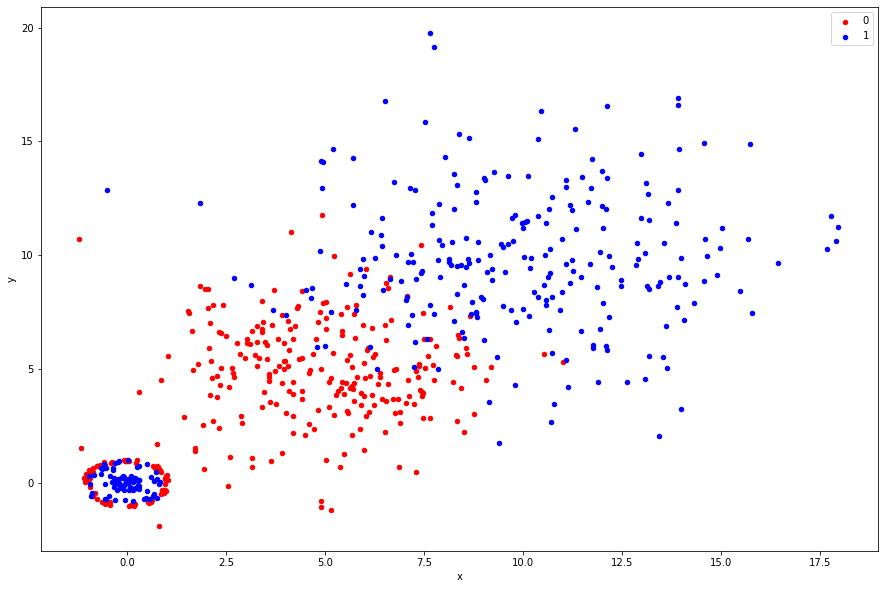

In [69]:
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = result.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

# RFLITE

In [75]:
df_2 = pd.DataFrame(zip(df_iid.x, df_iid.y))
df_2[len(df_2.columns)] = [i for i in df_iid.index]
df_2.rename(columns={len(df.columns)-1:'index'}, inplace=True)

In [76]:
# df_cp = df_cp.reset_index(drop=True)
## Target Dataset size ##
n = 400
K = 10
print(len(df_2))
y_original = df_iid['label']
# y_temp2 = df_iid['label']

y_temp2 = {}
for key, value in zip(df_iid.index,df_iid['label']):
    y_temp2[key]=value
y_original=y_temp2.copy()

960


In [77]:
# print(list(y_temp2.values()))

In [78]:
import math
lengths = {}
for key,lists in group_indices.items():
    lengths[key]=math.ceil(len(lists)*0.6)

In [79]:

while len(df_2) > n:
    #Dictionary to save the mdoel predictions for every individual elements.
    
    D = {}
    #m=64
    m=10
    for i in range(0,m):
        predictions,predictions_svm,X_train, X_test, y_train, y_test  = getPredictions(df_2,list(y_temp2.values()))
        print("Peek predictions")
        print(predictions[:10])
        print(predictions_svm[:10])
        for i in range(0,len(X_test)):
            index = X_test.iloc[i,len(X_test.columns)-1]
            if index not in D.keys():
                D[index] = [predictions[i],predictions_svm[i]]
            else:
                D[index].append(predictions[i])
                D[index].append(predictions_svm[i])

    #predictibility score
    print("Starting with Predictibility Scores")
    P = {}
    for key,value in D.items():
        P[key] = value.count(y_original[key])/len(value)

    X_new_index = {}
    print("The length of the Dictioanry is : "+str(len(P)))
    for key,value in P.items():
        ## 0.75 si the tao here
        ## First we select the instances where the predicitibility score was more than tao
        if value>=0.75:
            X_new_index[key] = value

    # Sort them based on value
    X_new_index = {k: v for k, v in sorted(X_new_index.items(), key=lambda item: item[1])}

    removed = 0
    for element in [*X_new_index][::-1]:
        if removed>=K:
            break
        for key, group in group_indices.items():
            if element in group:
                if len(group)-1 >= lengths[key]:
                    group.remove(element)
                    removed=removed+1
                    X_new_index.pop(element,None)

    if removed == 0:
        break
    
    df_prime = df_2[~df_2.index.isin(X_new_index.keys())]
    y_temp2={}
    for i in df_prime['index']:
        y_temp2[i]=df_iid.at[i,'label']

    print("New size after pruning")
    print(len(df_prime))
    # No more pruning possible
    if len(df_2) == len(df_prime):
        break
    df_2 = df_prime.copy()
    if len(df_2) < K:
        break
    # update labels as well

print(df_2)
print(X_new_index)

Iteration : 0
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[1 1 1 0 1 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
Iteration : 1
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[0 1 0 0 1 1 0 1 1 0]
[1 1 1 1 1 1 1 1 1 1]
Iteration : 2
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[0 1 0 1 0 1 1 0 1 0]
[0 0 1 0 0 1 0 1 0 1]
Iteration : 3
Training Samples: 
Test train Split
Logistic regression training complete
SVM training complete
Done with the predictions for LR
Done with the predictions for SVM
Peek predictions
[0 0 0 0 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0 1 0]
Iteration : 4
Training Samples: 
Test train Spli

In [83]:
label = [df_iid.at[i,'label'] for i in df_2['index']] 

In [ ]:
# df

In [84]:
X_new = df_2[[0,1]]

In [85]:
X_new = X_new.to_numpy()

#### Logistic Regression

In [86]:
lm = LogisticRegression(random_state=0,C=0.01,penalty = 'l2',max_iter=400)
lm.fit(X_new, label)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
predictions = lm.predict(X_test_iid)
predictions_ood = lm.predict(X_test_ood)

In [88]:
accuracy_score(predictions,y_test_iid)

0.7125

In [89]:
accuracy_score(predictions_ood,y_test_ood)

0.496875

#### SVM

In [90]:
rbf_svc = svm.SVC(kernel='rbf')
svc = svm.SVC()
rbf_svc.fit(X_new,label)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
predictions_svm = rbf_svc.predict(X_test_iid)
predictions_svm_ood = rbf_svc.predict(X_test_ood)

In [92]:
accuracy_score(predictions_svm,y_test_iid)

0.7833333333333333

In [93]:
accuracy_score(predictions_svm_ood,y_test_ood)

0.503125

In [94]:
result = DataFrame(X_new,columns=['x','y'])
result['label']=label

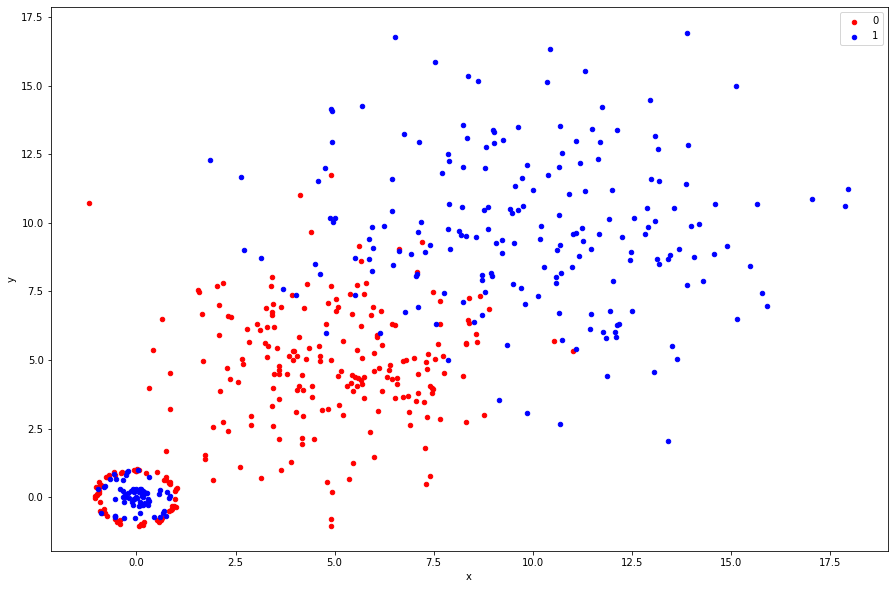

In [95]:
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = result.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()